In [1]:
# ignore future warning
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# processing of text
from preprocessing import Preprocessing

# models
import torch
import xgboost
from model_functions import train_validation_test_split, split_train_val_test, Modeling, add_to_table_xgboost
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

# inicjalize table for result
result = ''

In [2]:
data = Preprocessing()

In [3]:
data.load_data()
data.remove_quoting_comments()
data.demojize()
data.clean_text()
data.stopwords_remove()
data.lemmatize_text()
data.correct_typo_words()
data.token_join()
data.write_to_file()

# Model

In [4]:
X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test()

In [5]:
# tfidf_vectorizer = TfidfVectorizer()

# # TF-IDF feature matrix
# X_train = tfidf_vectorizer.fit_transform(X_train)
# X_test = tfidf_vectorizer.transform(X_test)

In [6]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train.astype('U').values)
X_val = vectorizer.transform(X_val.astype('U').values)

In [7]:
rf = Modeling(RandomForestClassifier(n_estimators=1000, random_state=0), 
              X_train, X_val, y_train, y_val, result,
              'Random Forest')
rf.fit_predict()
rf.print_results()
result = rf.add_to_table()

Results for Random Forest:
Random Forest accuracy: 0.836
Random Forest f-score: 0.8197
Random Forest recall: 0.836


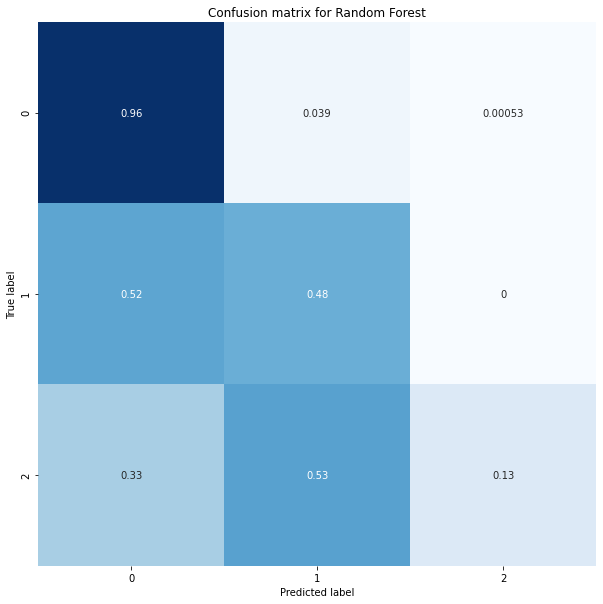

In [8]:
rf.plot_confusion_matrix_percent()

Results for Logistic Regression:
Logistic Regression accuracy: 0.8435
Logistic Regression f-score: 0.8299
Logistic Regression recall: 0.8435


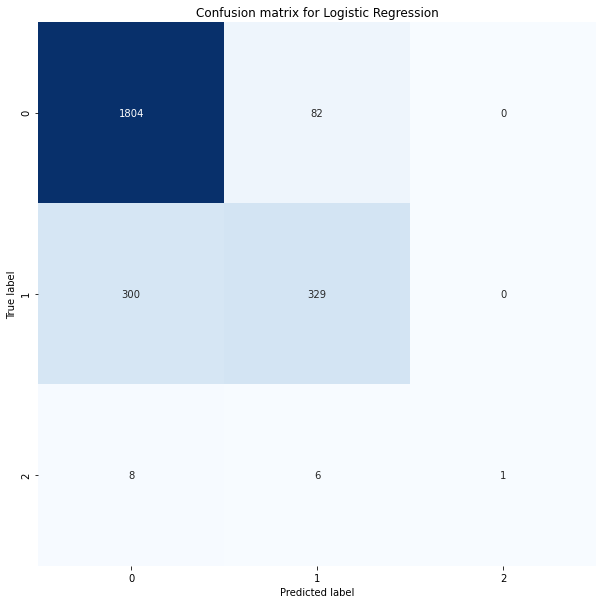

In [9]:
# Logistic Regression

log_reg = Modeling(LogisticRegression(solver='newton-cg'), 
                   X_train, X_val, y_train, y_val, result,
                   'Logistic Regression')
log_reg.fit_predict()
log_reg.print_results()
log_reg.plot_confusion_matrix()
result = log_reg.add_to_table()

Results for Logistic Regression SMOTE:
Logistic Regression SMOTE accuracy: 0.7304
Logistic Regression SMOTE f-score: 0.778
Logistic Regression SMOTE recall: 0.7304


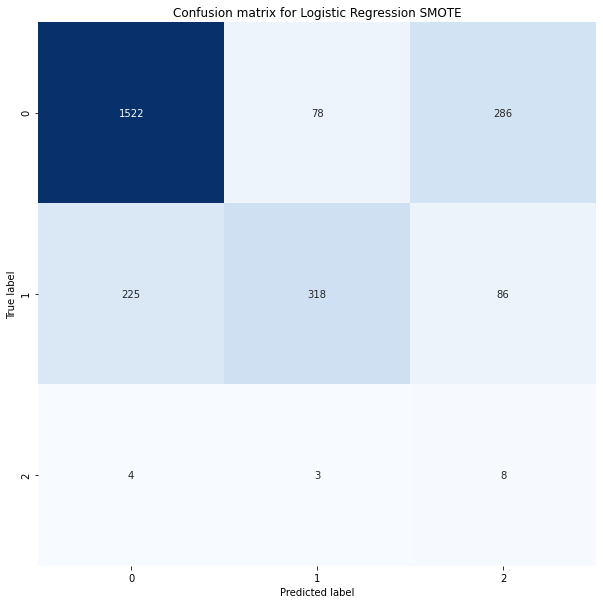

In [10]:
# SMOTE for Logistic Regression

log_reg_smote = Modeling(LogisticRegression(solver='newton-cg'), 
                         X_train, X_val, y_train, y_val, result,
                         'Logistic Regression SMOTE')
log_reg_smote.sample(SMOTE(sampling_strategy='minority'))
log_reg_smote.fit_predict()
log_reg_smote.print_results()
log_reg_smote.plot_confusion_matrix()
result = log_reg_smote.add_to_table()

Results for SVC:
SVC accuracy: 0.8273
SVC f-score: 0.8008
SVC recall: 0.8273


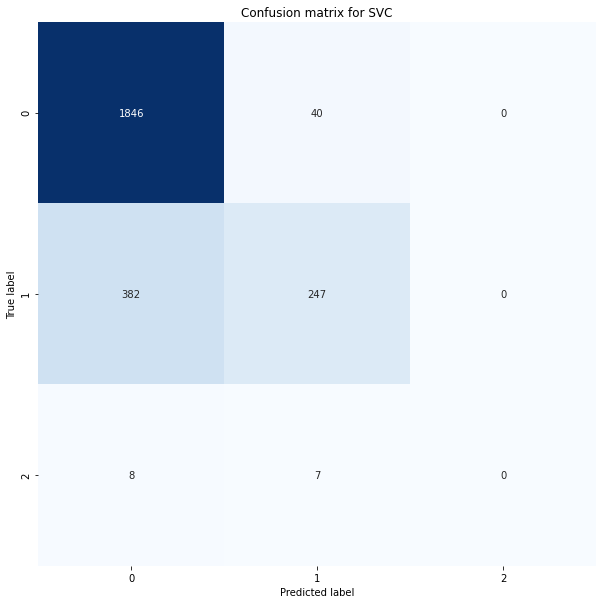

In [11]:
# SMOTE for Logistic Regression

svc = Modeling(SVC(probability=True), 
               X_train, X_val, y_train, y_val, result,
               'SVC')
svc.fit_predict()
svc.print_results()
svc.plot_confusion_matrix()
result = svc.add_to_table()

Results for SVC SMOTE:
SVC SMOTE accuracy: 0.7874
SVC SMOTE f-score: 0.7438
SVC SMOTE recall: 0.7874


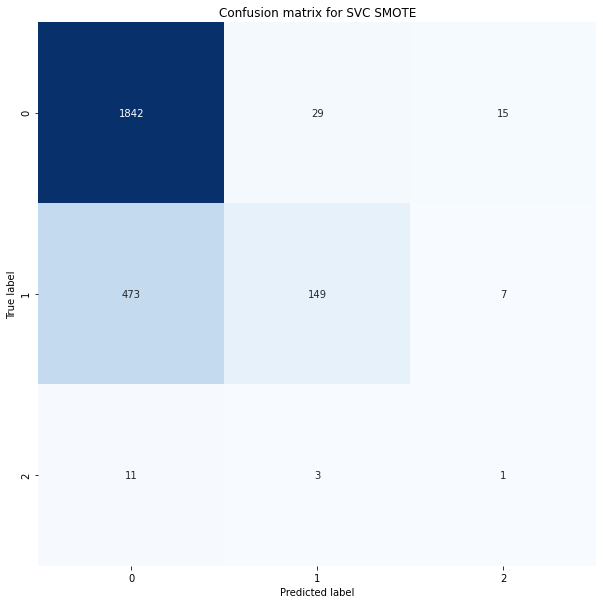

In [12]:
# SMOTE for Logistic Regression

svc_smote = Modeling(SVC(probability=True), 
                     X_train, X_val, y_train, y_val, result,
                     'SVC SMOTE')
svc_smote.sample(SMOTE(sampling_strategy='minority'))
svc_smote.fit_predict()
svc_smote.print_results()
svc_smote.plot_confusion_matrix()
result = svc_smote.add_to_table()

Results for Bayes:
Bayes accuracy: 0.8443
Bayes f-score: 0.8391
Bayes recall: 0.8443


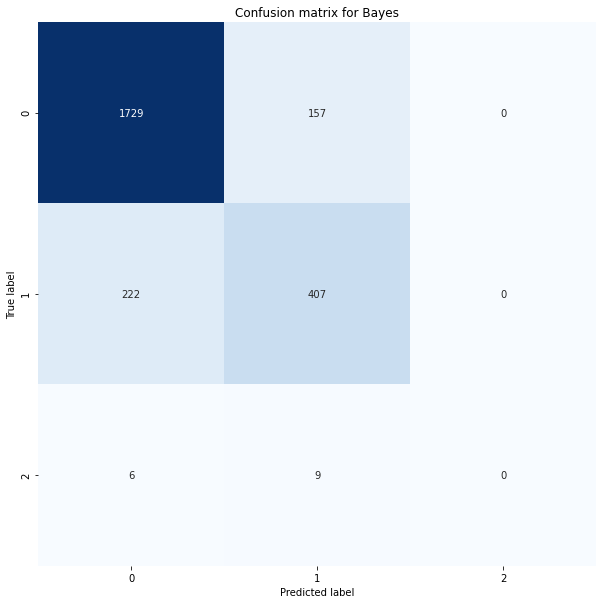

In [13]:
# Bayes
bayes = Modeling(MultinomialNB(), 
                 X_train, X_val, y_train, y_val, result,
                 'Bayes')
bayes.fit_predict()
bayes.print_results()
bayes.plot_confusion_matrix()
result = bayes.add_to_table()

Results for Bayes SMOTE:
Bayes SMOTE accuracy: 0.8209
Bayes SMOTE f-score: 0.8329
Bayes SMOTE recall: 0.8209


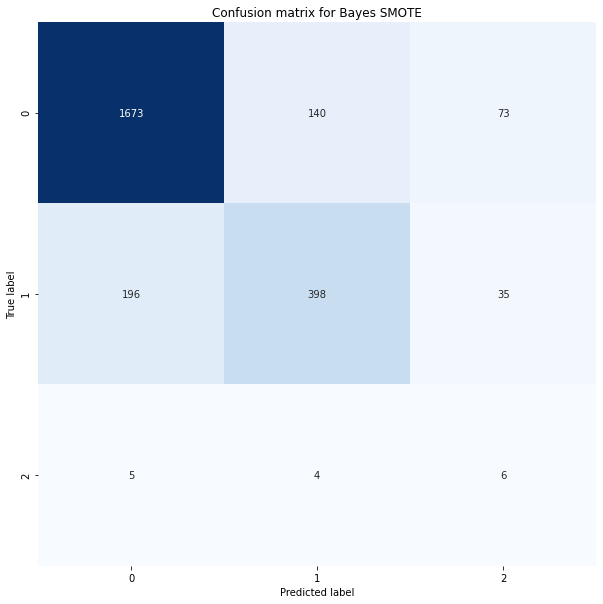

In [14]:
# SMOTE for Bayes
bayes_smote = Modeling(MultinomialNB(), 
                       X_train, X_val, y_train, y_val, result,
                       'Bayes SMOTE')
bayes_smote.sample(SMOTE(sampling_strategy='minority'))
bayes_smote.fit_predict()
bayes_smote.print_results()
bayes_smote.plot_confusion_matrix()
result = bayes_smote.add_to_table()

In [15]:
oversample = SMOTE()
X_train_s, y_train_s = oversample.fit_resample(X_train, y_train)
train = xgboost.DMatrix(X_train_s, label=y_train_s)
val = xgboost.DMatrix(X_val, label=y_val)

In [16]:
param = {'max_depth':50, 'eta':0.5, 'objective': 'multi:softmax', 'num_class': 3}
epochs=100
bst = xgboost.train(param, train, epochs)
# make prediction
preds = bst.predict(val)
result = add_to_table_xgboost(y_val, preds, result, 'XGboost')
print(classification_report(y_val,preds))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      1886
           1       0.74      0.57      0.64       629
           2       0.75      0.20      0.32        15

    accuracy                           0.84      2530
   macro avg       0.79      0.57      0.62      2530
weighted avg       0.83      0.84      0.83      2530



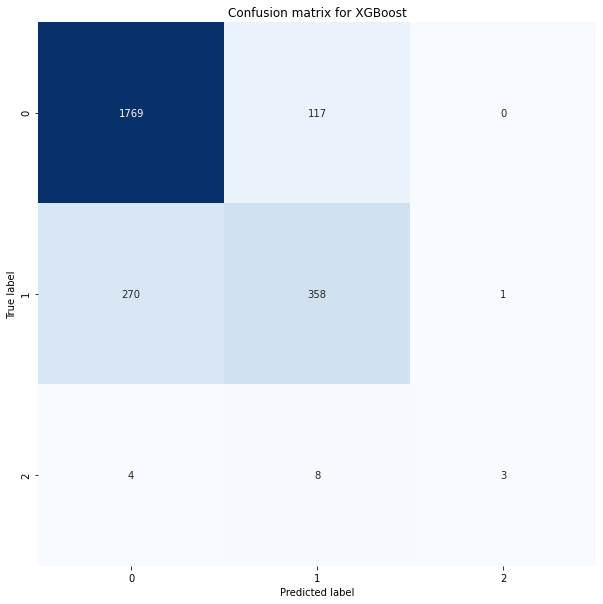

In [24]:
plot_confusion_matrix(y_val, preds, 'XGBoost')

In [18]:
result.transpose()

,Accuracy,F-score,Recall
Random Forest,0.8360,0.8197,0.8360
Logistic Regression,0.8435,0.8299,0.8435
Logistic Regression SMOTE,0.7304,0.7780,0.7304
SVC,0.8273,0.8008,0.8273
SVC SMOTE,0.7874,0.7438,0.7874
Bayes,0.8443,0.8391,0.8443
Bayes SMOTE,0.8209,0.8329,0.8209
XGboost,0.8419,0.8332,0.8419
